# Assignment 06 - Probabilistic and Statistical Methods (Total 23 Points)
<span style='color:red'> Due date: 22.06.2021 23:59</span>

This week's assignment is about the (purely) probabilistic and statistical methods we got to know and a bit of advanced regularization. If anything is unclear or if you find errors, feel free to post in the forum set up in Ilias or in the WebEx live session, or write an email to one of us.

_You can submit incomplete assignments that don't validate_. If a visible test cell validates correctly, you will get the points.

---

## Bayesian Regression (7 points)
Assume you have taken some measurement for determining a stress-strain curve of some material, and you want to create a model that is able to give you stresses for strains that you did not perform the experiment for. This is a regression task. Let's just take a modified version of the stress-strain curve we saw in lecture 02 again.

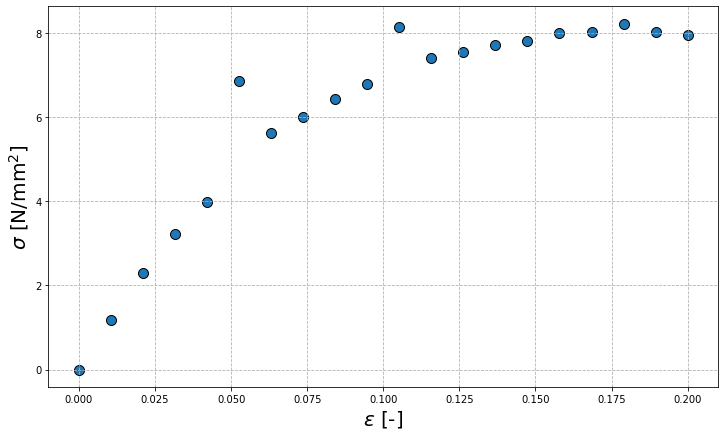

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, noise_var):
    noise = np.random.normal(0, noise_var, x.shape[0])
    return (10*x-2)**3 + 8 + noise

plt.figure(figsize=(12, 7))
plt.subplot(111)

samples = 20

ϵ = np.linspace(0, 2, samples)/10
σ = f(ϵ, 0.1)
σ[0]   = 0.0
σ[5]  += 2.1 #1.7
σ[10] += 1.0
#σ[10] -= 1.2

plt.xlabel(r"$\varepsilon$ [-]", fontsize=20)
plt.ylabel(r"$\sigma$ [N/mm$^2$]", fontsize=20)
plt.xlim([-0.01, 0.21])
plt.grid(True, linestyle="--")

plt.scatter(ϵ, σ, marker='o', s=100, edgecolor='k')

Now, we have *outliers* in the data, which can sometimes happen due to various environmental influences or errors in the experiment itself. The code below performs a regression as we have done in lecture 02:

In [2]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression

# polynomial degree to fit in both cases
degree = 3

# create polynomial features up to degree 3
poly = PolynomialFeatures(degree=degree)

# transform dataset for polynomial regression
ϵ_poly = poly.fit_transform(ϵ.reshape(-1, 1), σ)

# create linear regressor
lin = LinearRegression()

# fit the regressor to polynomial data
lin.fit(ϵ_poly, σ)

# create data to plot
X_plot = np.linspace(0, 0.2, 25)
y_plot = f(X_plot, noise_var=0)

# create predictions from linear regression
X_poly = poly.fit_transform(X_plot.reshape(-1, 1), y_plot)
y_linreg = lin.predict(X_poly)

So far, nothing new. We'll later use the result to compare it to what happens now. In the following code cell, set up the Bayesian regression by creating an instance of `BayesianRidge`, where `normalize` is set to `True` as an argument (which is needed for a sensible error margin). Use the variable `reg_poly` to adress the model.<br />
Then, fit `reg_poly` to the training data. In the lecture, we used the *Vandermonde* matrix to get polynomial features from the dataset. You can use it here as well. Set the degree to `degree+1`, because that parameter determines the number of columns, which is the number of polynomial degree plus 1, since the bias term is of degree 0.

In [3]:
from scipy import stats
from sklearn.linear_model import BayesianRidge

# This fixes the random number generator state
# Comment out to get randomness
np.random.seed(1)

# Setup the Bayesian polynomial regression in a variable called 'reg_poly',
# then fit your model to the polynomial data from the experiment above
### BEGIN SOLUTION
reg_poly = BayesianRidge(normalize=True)

# Fit the model, vander() creates polynomial features (Vandermonde matrix)
reg_poly.fit(np.vander(ϵ, degree+1), σ)
### END SOLUTION

BayesianRidge(normalize=True)

Create the predictions `y_mean` and `y_std` from the Bayesian regression below (like in the lecture) for `X_plot` in polynomial form:

In [5]:
# Get predictions and standard deviations for error bands 
### BEGIN SOLUTION
y_mean, y_std = reg_poly.predict(np.vander(X_plot, degree+1), return_std=True)
### END SOLUTION

In [9]:
assert max(y_std) < 0.63
assert max(y_mean) < 8.5


If everything worked, you should see graphs of both regression approaches below.

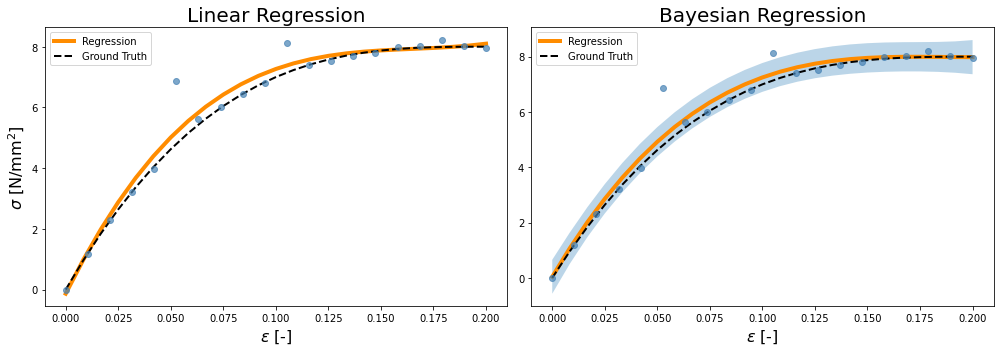

In [10]:
# Plotting setup
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot ground truth, prediction, "continuous" error bars
axs[0].plot(X_plot, y_linreg, color='darkorange', lw=4, label='Regression')
axs[0].plot(X_plot, y_plot, color='black', linewidth=2,
         linestyle='--', label="Ground Truth")
axs[0].scatter(ϵ, σ, zorder=20, color='steelblue', alpha=0.7)

axs[0].set_title("Linear Regression", fontsize=20)
axs[0].set_ylabel(r"$\sigma$ [N/mm$^2$]", fontsize=16)
axs[0].set_xlabel(r"$\varepsilon$ [-]", fontsize=16)
axs[0].legend()

axs[1].plot(X_plot, y_mean, color='darkorange', lw=4, label='Regression')
axs[1].plot(X_plot, y_plot, color='black', linewidth=2,
         linestyle='--', label="Ground Truth")
axs[1].fill_between(X_plot, y_mean+y_std, y_mean-y_std, alpha=0.3)
axs[1].scatter(ϵ, σ, zorder=20, color='steelblue', alpha=0.7)

axs[1].set_title("Bayesian Regression", fontsize=20)
#axs[1].set_ylabel("σ", fontsize=16)
axs[1].set_xlabel(r"$\varepsilon$ [-]", fontsize=16)
axs[1].legend()

plt.tight_layout()

To a certain extent, Bayesian regression is more robust against outliers. The result of the Bayesian regression on the right should fit the ground truth a little bit better than the result from linear regression. This should be visible especially in the beginning and at the end of the curve. This is not reflected in the R² scores, which should be roughly equal:

In [11]:
from sklearn.metrics import r2_score

print("R² score from linear regression:   ", r2_score(σ, lin.predict(ϵ_poly)))
print("R² score from Bayesian regression: ", r2_score(σ, reg_poly.predict(np.vander(ϵ, degree+1))))

R² score from linear regression:    0.9649714274916664
R² score from Bayesian regression:  0.9640547284450881


---

## Custom Callbacks (10 Points)
We talked about how to provide callback function during training to influence what happens during training. To have more control over what happens, we can write our own callback called `CustomCallback` by "inheriting" from the `Callback` class (*inheritance is an object-oriented programming concept, you don't need to worry about it, it pretty much just means it's the same thing, but we can add a bit of code and change things without writing everything from scratch*). You can find a full example in the [documentation](https://www.tensorflow.org/guide/keras/custom_callback). 

The way this works is that at certain points during the training, corresponding *methods* of our custom class are called. E.g., after an epoch ends, the `on_epoch_end()` method is called with some *arguments* and its body is executed. The main argument for each call is the `logs` object, which contains information about the current state of the training. 

Before we start writing the callback, let's create a simple model that performs a regression on the dataset from the last exercise (the stress-strain curve) above. Think about how many input and output neurons you need. Use two hidden layer with 10 neurons each and `tanh` activation. We will *rescale* all our data later on, so you can also use `tanh` activation in the output layer. 

Afterwards, `compile` your model as well with the `adam` optimizer and an appropriate loss function. The `summary` should show 141 trainable parameters.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session

clear_session()

model = Sequential()

# add three dense layers to the model here, as described above
# then compile your model
### BEGIN SOLUTION
model.add(Dense(10, input_shape=(1,1), activation="tanh"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(1, activation="tanh"))

model.compile(optimizer="adam", loss="mse")
### END SOLUTION

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 10)             20        
_________________________________________________________________
dense_1 (Dense)              (None, 1, 10)             110       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [8]:
assert model.count_params() == 141
for layer in model.layers:
    assert "tanh" in str(layer.activation)



We already talked about normalization and why it's a good idea. An easy way to normalize data is to use one of the `Scaler`s from `scikit-learn`. You can check out the [documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) to find out what each of them does. Here, we'll use the `MinMaxScaler`, to squish the data range to $[0,1]$. Hence, we can use `tanh` as activations in each layer without any problems.

The code below shows how this works. A scaler object is instantiated from the class for input and output data each. The scaler is "fit" to the data, after which it can "transform" it to the desired range. Both these steps can be done with a single function call to `fit_transform()`. We're also going to plot the ground truth later on, so those values are transformed without fitting again. We'll take the training data as reference, since some outliers may have a higher value than anything in the ground truth.

In [9]:
from sklearn.preprocessing import MinMaxScaler

# instantiate the scalers
ϵ_scaler = MinMaxScaler()
σ_scaler = MinMaxScaler()

# fit and transform the data
ϵ_scaled = ϵ_scaler.fit_transform(ϵ.reshape(-1,1))
σ_scaled = σ_scaler.fit_transform(σ.reshape(-1,1))

# transform the ground truth as well
ϵ_gt = ϵ_scaler.transform(X_plot.reshape(-1,1))
σ_gt = σ_scaler.transform(y_plot.reshape(-1,1))

# check the value range
ϵ_scaled

array([[0.        ],
       [0.05263158],
       [0.10526316],
       [0.15789474],
       [0.21052632],
       [0.26315789],
       [0.31578947],
       [0.36842105],
       [0.42105263],
       [0.47368421],
       [0.52631579],
       [0.57894737],
       [0.63157895],
       [0.68421053],
       [0.73684211],
       [0.78947368],
       [0.84210526],
       [0.89473684],
       [0.94736842],
       [1.        ]])

With the setup out of the way, we can use a very simple callback function to see what is contained in the `logs` object:

In [10]:
from tensorflow.keras.callbacks import Callback

# The class name here is arbitrary, but note the use of "Callback" in the 
# class argument. This means we "copy" the Callback class and change it 
# to what we need
class SimpleCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        print("on_epoch_end logs type: ", type(logs))
        print("on_epoch_end logs:", logs)
        # ignore the return statement, it's not necessary and should be left out
        return epoch, logs
        

# instantiate an object that we can use in model.fit() later
simpleCallback = SimpleCallback()

In the cell below, train the model from above on the `ϵ_scaled`-`σ_scaled`data that we rescaled further up. Use a single `epoch`, and provide the `simpleCallback` function as a callback. We'll omit creating training and test sets, since there's not much data at all and we already know how to use a test set.

In [11]:
### BEGIN SOLUTION
model.fit(ϵ_scaled, σ_scaled, epochs=1, callbacks=simpleCallback)
### END SOLUTION

1/1 [==============================] - 1s 779ms/step - loss: 0.5440
on_epoch_end logs type:  <class 'dict'>
on_epoch_end logs: {'loss': 0.5440124273300171}


on_epoch_end logs type:  <class 'dict'>
on_epoch_end logs: {'loss': 32}


For such a simple model, the `logs`object is a `dict` that only contains the loss information (it would also contain information, e.g., about each metric added for more complex models). We can use this for an *early stopping* mechanism to prevent overfitting. To spice things up, we'll also plot the loss and validation loss live during training, which is a bit less heavy than using `tensorboard`. Adding to this, we'll also plot each epoch's prediction and compare it to ground truth and training data.

Complete the code below with a conditional statement that checks whether the current loss is below $3.3\cdot 10^{-3}$, then sets `self.model.stop_training` to `True`. This will immediately and gracefully stop the training process. You can add a `print()` statement too, that informs you about the circumstances and the epoch in which the early stop was triggered. You could use `print(f"Loss < 3.3e-3, stopping training early at epoch {epoch}")` for example.

In [13]:
from IPython.display import clear_output

class CustomCallback(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        

    def on_epoch_end(self, epoch, logs={}):
        self.x.append(epoch)
        self.losses.append(logs["loss"])
        self.val_losses.append(logs["val_loss"])
        
        clear_output(wait=True)
        
        fig, axs = plt.subplots(1,2, figsize=(16,7))
        
        axs[0].plot(self.x, self.losses, lw=4, label="loss")
        axs[0].plot(self.x, self.val_losses, lw=4, label="val_loss")
        axs[0].legend(fontsize=16)
        axs[0].set_xlabel("Epoch", fontsize=16)
        axs[0].set_ylabel("Loss", fontsize=16)
        #axs[0].set_yscale("log")
        
        epoch_pred = self.model.predict(ϵ_scaled).reshape(20,1)
        
        axs[1].scatter(ϵ_scaled, σ_scaled, lw=4, label="Data")
        axs[1].plot(ϵ_gt, σ_gt, color='black', linewidth=2,
         linestyle='--', label="Ground Truth")
        axs[1].plot(ϵ_scaled, epoch_pred, lw=4, color="darkorange", label=f"Prediction Epoch {epoch+1}")
        axs[1].set_ylabel(r"$\sigma$ [N/mm$^2$]", fontsize=16)
        axs[1].set_xlabel(r"$\varepsilon$ [-]", fontsize=16)
        #axs[1].set_yscale("log")

        axs[1].legend(fontsize=16)
        
        plt.show()
        
        # place your conditional statement here
        # it should check whether the current loss is below 3.3*10^-3 and then
        # set self.model.stop_training to True
        # you can additionally provide a print() statement
        ### BEGIN SOLUTION
        if logs["loss"][-1] < 3.3e-3:
            print(f"Loss < 3.3e-3, stopping training early at epoch {epoch}")
            self.model.stop_training = True
        ### END SOLUTION
        
customCallback = CustomCallback()

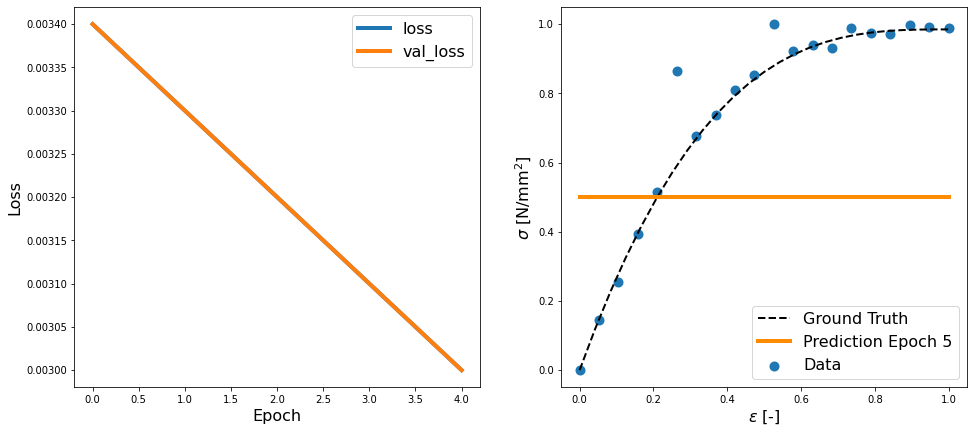

Loss < 3.3e-3, stopping training early at epoch 4
[False, False, True, True, True]


Test the custom callback in the next cell by fitting the model to `ϵ_scaled` and `σ_scaled`. Use 100 `epochs`, a `validation_split` of 0.05 and a `batch_size` of 1. Provide the custom callback from above as well. You should see a good training curve on the left and predictions on the right that become better with more training. You don't need to save the history in an extra variable.

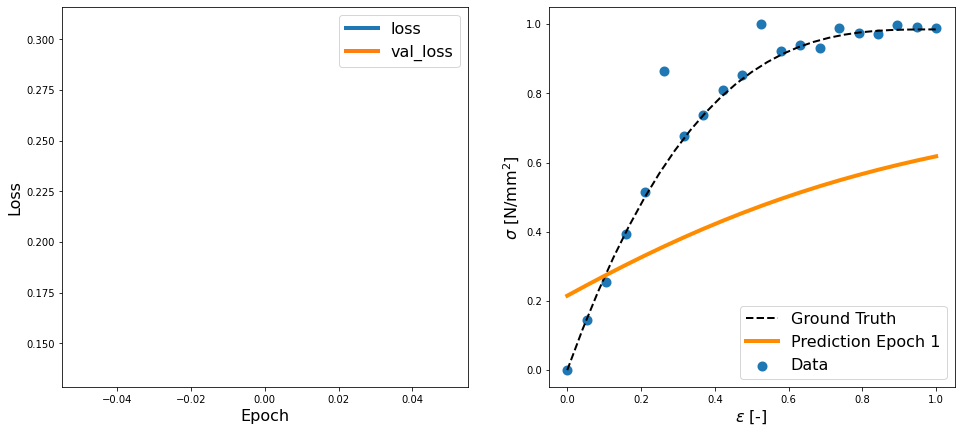

TypeError: 'float' object is not subscriptable

In [15]:
### BEGIN SOLUTION
model.fit(ϵ_scaled, σ_scaled, epochs=100, validation_split=0.05, batch_size=1, callbacks=customCallback)
### END SOLUTION

In [ ]:
assert model.history.epoch[-1] < 80
assert model.stop_training == True
assert model.history.history["loss"][-1] < 3.3e-3
assert model.history.params["epochs"] == 100
assert model.history.params["steps"] == 19

Of course simply testing for the loss value itself isn't too sensible. It's almost impossible to anticipate a certain loss value and expect a good fit for that value. Instead, one could create a list of the past $x$ losses and see whether it still decreases sufficiently, or compare them to the validation losses to detect overfitting. It's usually much better to resort to the callbacks provided by `tensorflow` itself. 

The validation curve is not reliable, since we're only using a single sample here.

---

## Dropout (6 Points)
We discussed *Droupout* regularization briefly in the lecture. Reimplement the exact same model that you used in the exdercise above, but this time, double the number of neurons in each *hidden* layer. Then, add a `Dropout` layer after each hidden layer with a dropout rate of 0.5. Call the model `reg_model` to not overwrite the one from before.

In [54]:
from tensorflow.keras.layers import Dropout

clear_session()

reg_model = Sequential()

### BEGIN SOLUTION
reg_model.add(Dense(20, input_shape=(1,1), activation="tanh"))
reg_model.add(Dropout(0.5))
reg_model.add(Dense(20, activation="tanh"))
reg_model.add(Dropout(0.5))
reg_model.add(Dense(1, activation="tanh"))

reg_model.compile(optimizer="adam", loss="mse")
### END SOLUTION

reg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 20)             40        
_________________________________________________________________
dropout (Dropout)            (None, 1, 20)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 20)             420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 1)              21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


Fit this regularized model again exactly like above, with 100 `epochs`, a `validation_split` of 0.05, a `batch_size` of 1 and the custom callback.

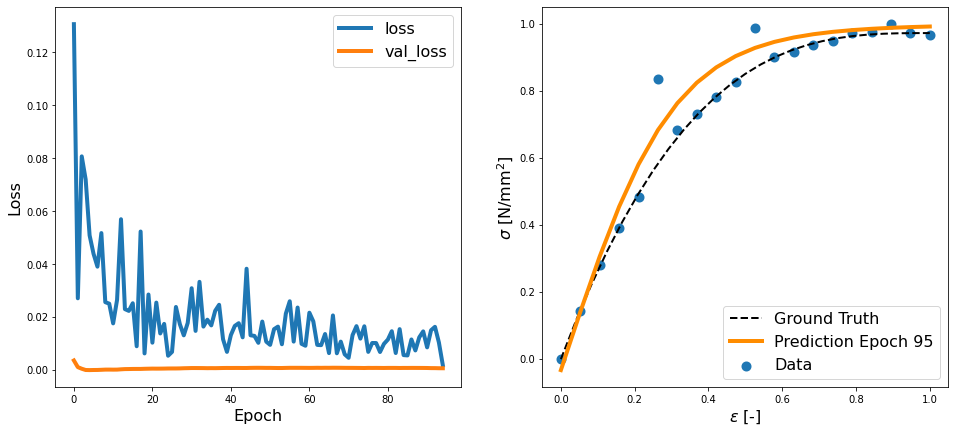

Loss < 3.3e-3, stopping training early at epoch 94


In [56]:
### BEGIN SOLUTION
reg_model.fit(ϵ_scaled, σ_scaled, epochs=100, validation_split=0.05, batch_size=1, callbacks=customCallback)
### END SOLUTION

In [57]:
assert reg_model.history.epoch[-1] < 99
assert reg_model.stop_training == True
assert reg_model.history.history["loss"][-1] < 3.3e-3
assert reg_model.history.params["epochs"] == 100
assert reg_model.history.params["steps"] == 19

You should see that this model takes longer to train to an acceptable state, but is less prone to deformations caused by the outliers. The training curve should look more messy due to the way dropout works. A simple weight regularization would work better here, but in more complex situations `Dropout` provides a better way to regularize especially large models.

Due to the stochastic nature of the training, you may have to restart the process to get good results.

---